In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cpu')

**Load the toxcast dataset**

In [4]:
loaded_toxcast_features_train_val_test = np.load('../preprocessing/preprocessed_data/toxcast_features_train_val_test.npy', allow_pickle=True).item()

loaded_toxcast_ecfp_descr_quantiles_scaled_X_train = loaded_toxcast_features_train_val_test['train']
loaded_toxcast_ecfp_descr_quantiles_scaled_X_val = loaded_toxcast_features_train_val_test['validation']
loaded_toxcast_ecfp_descr_quantiles_scaled_X_test = loaded_toxcast_features_train_val_test['test']

In [5]:
toxcast_features = np.concatenate((loaded_toxcast_ecfp_descr_quantiles_scaled_X_train,
                                  loaded_toxcast_ecfp_descr_quantiles_scaled_X_val,
                                  loaded_toxcast_ecfp_descr_quantiles_scaled_X_test), axis=0)

In [6]:
toxcast_features.shape

(8595, 2248)

In [7]:
loaded_toxcast_labels_train_val_test = np.load('../preprocessing/preprocessed_data/toxcast_labels_train_val_test.npy', allow_pickle=True).item()

loaded_toxcast_y_train = loaded_toxcast_labels_train_val_test['train']
loaded_toxcast_y_val = loaded_toxcast_labels_train_val_test['validation']
loaded_toxcast_y_test = loaded_toxcast_labels_train_val_test['test']

In [8]:
toxcast_labels = np.concatenate((loaded_toxcast_y_train,
                                  loaded_toxcast_y_val,
                                  loaded_toxcast_y_test), axis=0)

In [9]:
toxcast_labels.shape

(8595, 617)

**Split the dataset into validation and test sets and create splits for each task**

In [10]:
toxcast_labels_val = toxcast_labels[:,:308]
toxcast_labels_test = toxcast_labels[:,308:617]

In [11]:
toxcast_labels_val.shape, toxcast_labels_test.shape

((8595, 308), (8595, 309))

In [12]:
def split_indices_for_task(task_labels):
    active_indices = np.where(task_labels == 1)[0]
    inactive_indices = np.where(task_labels == 0)[0]

    np.random.seed(42)
    selected_active = np.random.choice(active_indices, size=5, replace=False)
    selected_inactive = np.random.choice(inactive_indices, size=5, replace=False)

    rest_indices = np.setdiff1d(np.arange(task_labels.shape[0]), np.concatenate([selected_active, selected_inactive]))

    return selected_active, selected_inactive, rest_indices

def process_indices_for_all_tasks(toxcast_labels_val):
    all_tasks_indices = []

    for task in range(toxcast_labels_val.shape[1]):
        task_labels = toxcast_labels_val[:, task]

        selected_active, selected_inactive, rest_indices = split_indices_for_task(task_labels)

        task_indices = {
            "task": task,
            "indices_active": selected_active,
            "indices_inactive": selected_inactive,
            "indices_rest": rest_indices
        }

        all_tasks_indices.append(task_indices)

    return all_tasks_indices

In [13]:
val_tasks_indices = process_indices_for_all_tasks(toxcast_labels_val)
test_tasks_indices = process_indices_for_all_tasks(toxcast_labels_test)

In [14]:
val_tasks_indices[0]

{'task': 0,
 'indices_active': array([6522, 2862, 1497, 7059, 1526], dtype=int64),
 'indices_inactive': array([6568, 1766, 2715, 6455, 3518], dtype=int64),
 'indices_rest': array([   0,    1,    2, ..., 8592, 8593, 8594])}

In [15]:
test_tasks_indices[0]

{'task': 0,
 'indices_active': array([6210, 4636, 6840, 1168, 3190], dtype=int64),
 'indices_inactive': array([7281, 1869, 6455, 3755, 1701], dtype=int64),
 'indices_rest': array([   0,    1,    2, ..., 8592, 8593, 8594])}

In [16]:
toxcast_features = torch.tensor(toxcast_features, dtype=torch.float32).to(device)
toxcast_labels_val = torch.tensor(toxcast_labels_val, dtype=torch.float32).to(device)

**Create a new logistic regression model**

In [17]:
def create_layer(in_size, out_size, activation_function=nn.ReLU, p=0.25):
    return nn.Sequential(
        nn.AlphaDropout(p=p),
        nn.Linear(in_size, out_size),
        activation_function()
    )


class DNN(nn.Module):
    def __init__(self, input_layer, hidden_layers, output_layer, activation_function=nn.ReLU, p=0.25):
        super().__init__()

        self.input_layer = nn.Linear(input_layer, hidden_layers[0])
        self.act1 = activation_function()
        self.dropout1 = nn.AlphaDropout(p=p)

        layers = [create_layer(hl_in, hl_out, activation_function, p) for hl_in, hl_out in zip(hidden_layers, hidden_layers[1:])]

        self.hidden_layers = nn.Sequential(*layers)

        self.output_layer = nn.Linear(hidden_layers[-1], output_layer)

    def forward(self, x):
        x = self.dropout1(x)
        x = self.act1(self.input_layer(x))
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x

params = {'input_size': 2248,
          'hidden_layers': [1024, 128],
          'output_size': 12,
          'activation_function': nn.SELU,
          'dropout_p': 0.45
         }

input_size, hidden_layers, output_size, activation_function, dropout_p = params.values()


class LRNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.output_layer = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.output_layer(x)
        x = self.sigmoid(x)
        return x

model = DNN(input_size, hidden_layers, output_size, activation_function, p=dropout_p)
model.load_state_dict(torch.load('../pretraining/training/dnn_best_model.pth', map_location=device))

<All keys matched successfully>

In [18]:
model.to(device)

DNN(
  (input_layer): Linear(in_features=2248, out_features=1024, bias=True)
  (act1): SELU()
  (dropout1): AlphaDropout(p=0.45, inplace=False)
  (hidden_layers): Sequential(
    (0): Sequential(
      (0): AlphaDropout(p=0.45, inplace=False)
      (1): Linear(in_features=1024, out_features=128, bias=True)
      (2): SELU()
    )
  )
  (output_layer): Linear(in_features=128, out_features=12, bias=True)
)

**Feature propagation**

In [19]:
def extract_features(model, features):
    model.eval()
    with torch.no_grad():
        last_hl_output = model.input_layer(features)
        last_hl_output = model.act1(last_hl_output)
        last_hl_output = model.hidden_layers(last_hl_output)
    return last_hl_output

def cosine_similarity_matrix(features):
    norm_features = features / torch.norm(features, dim=1, keepdim=True)
    return torch.mm(norm_features, norm_features.t())

def build_graph(features, k=15):
    cosine_sim = cosine_similarity_matrix(features)
    adjacency_matrix = torch.zeros_like(cosine_sim)

    for i in range(cosine_sim.size(0)):
        top_k_indices = torch.topk(cosine_sim[i, :], k+1, largest=True, sorted=True).indices
        top_k_indices = top_k_indices[top_k_indices != i]
        adjacency_matrix[i, top_k_indices] = cosine_sim[i, top_k_indices]

    degree_matrix = torch.diag(adjacency_matrix.sum(dim=1))
    eps = 0
    degree_inv_sqrt = torch.diag(1 / torch.sqrt(torch.diag(degree_matrix) + eps))
    normalized_adjacency = torch.mm(torch.mm(degree_inv_sqrt, adjacency_matrix), degree_inv_sqrt)

    return normalized_adjacency

def feature_propagation(features, normalized_adjacency, alpha=0.75, k=1):
    identity_matrix = torch.eye(features.size(0), device=features.device)
    diffusion_matrix = torch.matrix_power(alpha * identity_matrix + normalized_adjacency, k)
    propagated_features = torch.mm(diffusion_matrix, features)
    return propagated_features

**Train & validation loop**

In [20]:
def train_validate_task(
    lr_model,
    train_features_propagated,
    train_labels,
    val_features_propagated,
    val_labels,
    optimizer,
    criterion
):
    lr_model.train()
    optimizer.zero_grad()
    outputs = lr_model(train_features_propagated)
    loss = criterion(outputs, train_labels)
    loss.backward()
    optimizer.step()

    lr_model.eval()
    with torch.no_grad():
        val_outputs = lr_model(val_features_propagated)

        valid_mask = val_labels != -1
        filtered_val_outputs = val_outputs[valid_mask]
        filtered_val_labels = val_labels[valid_mask]

        val_loss = criterion(filtered_val_outputs, filtered_val_labels).item()
        filtered_val_outputs = filtered_val_outputs.cpu().numpy()
        filtered_val_labels = filtered_val_labels.cpu().numpy()

    if len(filtered_val_labels) > 0 and len(np.unique(filtered_val_labels)) > 1:
        roc_auc = roc_auc_score(filtered_val_labels, filtered_val_outputs)
    else:
        roc_auc = float('nan')

    return loss.item(), val_loss, roc_auc

def train_all_tasks(
    dnn_model,
    toxcast_features,
    toxcast_labels_val,
    val_tasks_indices,
    num_epochs=10,
    learning_rate=1e-3,
    patience=3,
    k=15,
    alpha=0.75,
    diffusion_k=1,
    propagate_features=True
):
    all_features = extract_features(dnn_model, toxcast_features)
    
    if propagate_features:
        normalized_adjacency = build_graph(all_features, k=k)
        all_features_propagated = feature_propagation(all_features, 
                                                      normalized_adjacency, 
                                                      alpha=alpha, 
                                                      k=diffusion_k)
    else:
        all_features_propagated = all_features

    all_train_losses_per_epoch = []
    all_val_losses_per_epoch = []
    mean_roc_aucs_per_epoch = []

    best_mean_roc_auc = float('-inf')
    best_epoch = -1
    no_improvement_counter = 0

    best_models = {}

    models = {}
    optimizers = {}
    criterions = {}

    for task_indices in val_tasks_indices:
        input_size = hidden_layers[-1]
        task_model = LRNN(input_size)
        task_model.to(device)
        optimizer = optim.Adam(task_model.parameters(), lr=learning_rate)

        models[task_indices['task']] = task_model
        optimizers[task_indices['task']] = optimizer
        criterions[task_indices['task']] = nn.BCELoss()

    for epoch in range(num_epochs):
        epoch_train_losses = []
        epoch_val_losses = []
        epoch_roc_aucs = []
        total_train_loss = 0
        total_val_loss = 0

        for task_indices in val_tasks_indices:
            task_model = models[task_indices['task']]
            optimizer = optimizers[task_indices['task']]
            criterion = criterions[task_indices['task']]

            active_indices = task_indices['indices_active']
            inactive_indices = task_indices['indices_inactive']
            rest_indices = task_indices['indices_rest']

            train_indices = np.concatenate([active_indices, inactive_indices])
            train_features_propagated = all_features_propagated[train_indices]
            train_labels = toxcast_labels_val[train_indices, task_indices['task']].clone().detach().unsqueeze(1)

            val_features_propagated = all_features_propagated[rest_indices]
            val_labels = toxcast_labels_val[rest_indices, task_indices['task']].clone().detach().unsqueeze(1)

            train_loss, val_loss, roc_auc = train_validate_task(
                task_model,
                train_features_propagated,
                train_labels,
                val_features_propagated,
                val_labels,
                optimizer,
                criterion
            )

            epoch_train_losses.append(train_loss)
            epoch_val_losses.append(val_loss)
            epoch_roc_aucs.append(roc_auc)
            total_train_loss += train_loss
            total_val_loss += val_loss

        mean_roc_auc = np.nanmean(epoch_roc_aucs)

        all_train_losses_per_epoch.append(total_train_loss)
        all_val_losses_per_epoch.append(total_val_loss)
        mean_roc_aucs_per_epoch.append(mean_roc_auc)

        if mean_roc_auc > best_mean_roc_auc:
            best_mean_roc_auc = mean_roc_auc
            best_epoch = epoch
            no_improvement_counter = 0

            for task_indices in val_tasks_indices:
                best_models[task_indices["task"]] = models[task_indices['task']].state_dict()
        else:
            no_improvement_counter += 1

        if no_improvement_counter >= patience:
            print(f"Early stopping after {epoch + 1} epochs. Best ROC AUC: {best_mean_roc_auc:.4f} at epoch {best_epoch + 1}")
            break

        print(f'Epoch {epoch + 1}/{num_epochs} - Mean ROC AUC: {mean_roc_auc:.4f}, '
              f'Total Train Loss: {total_train_loss:.4f}, '
              f'Total Validation Loss: {total_val_loss:.4f}, '
              f'Best ROC AUC: {best_mean_roc_auc}')

    torch.save(best_models, 'best_models_val.pth')

    return all_train_losses_per_epoch, all_val_losses_per_epoch, mean_roc_aucs_per_epoch, best_epoch

In [21]:
%%time
val_aucs_fp = []
for _ in range(10):
    train_losses_per_epoch, val_losses_per_epoch, mean_roc_aucs_per_epoch, best_epoch = train_all_tasks(
        model,
        toxcast_features,
        toxcast_labels_val,
        val_tasks_indices,
        num_epochs=100,
        learning_rate=1e-2,
        patience=5,
        k=256,
        alpha=0,
        diffusion_k=1,
        propagate_features=True
    )
    
    val_aucs_fp.append(mean_roc_aucs_per_epoch[best_epoch])

Epoch 1/100 - Mean ROC AUC: 0.5839, Total Train Loss: 295.1689, Total Validation Loss: 221.5067, Best ROC AUC: 0.5839392659622431
Epoch 2/100 - Mean ROC AUC: 0.6333, Total Train Loss: 206.0998, Total Validation Loss: 216.2375, Best ROC AUC: 0.6332848573150126
Epoch 3/100 - Mean ROC AUC: 0.6465, Total Train Loss: 172.8370, Total Validation Loss: 231.4173, Best ROC AUC: 0.6464861305224092
Epoch 4/100 - Mean ROC AUC: 0.6481, Total Train Loss: 154.6155, Total Validation Loss: 254.8386, Best ROC AUC: 0.6481388765304055
Epoch 5/100 - Mean ROC AUC: 0.6472, Total Train Loss: 143.7957, Total Validation Loss: 277.0637, Best ROC AUC: 0.6481388765304055
Epoch 6/100 - Mean ROC AUC: 0.6456, Total Train Loss: 133.6993, Total Validation Loss: 294.7633, Best ROC AUC: 0.6481388765304055
Epoch 7/100 - Mean ROC AUC: 0.6438, Total Train Loss: 123.3497, Total Validation Loss: 309.0549, Best ROC AUC: 0.6481388765304055
Epoch 8/100 - Mean ROC AUC: 0.6421, Total Train Loss: 114.5633, Total Validation Loss: 321

In [29]:
val_aucs_fp = np.array(val_aucs_fp)
print(f'Validation ROC AUC = {np.mean(val_aucs_fp):.4f}±{np.std(val_aucs_fp):.4f}')

Validation ROC AUC = 0.6470±0.0031


**Plot training results**

In [23]:
def plot_training_results(train_losses, val_losses, mean_roc_aucs, best_epoch):
    epochs = range(1, len(train_losses) + 1)

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].plot(epochs, train_losses, label='train Loss', color='blue')
    ax[0].plot(epochs, val_losses, label='validation Loss', color='orange')
    ax[0].scatter([best_epoch + 1], [train_losses[best_epoch]], color='red', label='best model', zorder=5)
    ax[0].scatter([best_epoch + 1], [val_losses[best_epoch]], color='red', zorder=5)
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].set_title('train and validation loss per epoch')
    ax[0].legend()

    ax[1].plot(epochs, mean_roc_aucs, label='mean ROC AUC', color='green')
    ax[1].scatter([best_epoch + 1], [mean_roc_aucs[best_epoch]], color='red', label='best model', zorder=5)
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('mean ROC AUC')
    ax[1].set_title('mean ROC AUC per epoch')
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

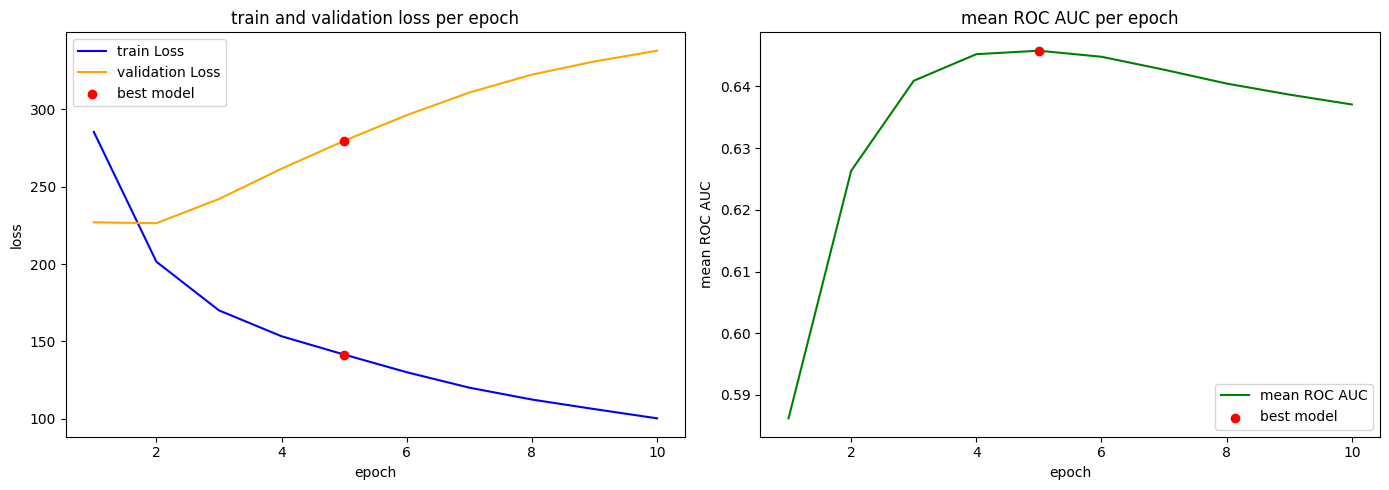

In [24]:
plot_training_results(train_losses_per_epoch, 
                      val_losses_per_epoch, 
                      mean_roc_aucs_per_epoch, 
                      best_epoch)

**Train and validation without feature propagation**

In [25]:
%%time
val_aucs = []
for _ in range(10):
    train_losses_per_epoch, val_losses_per_epoch, mean_roc_aucs_per_epoch, best_epoch = train_all_tasks(
        model,
        toxcast_features,
        toxcast_labels_val,
        val_tasks_indices,
        num_epochs=100,
        learning_rate=1e-2,
        patience=5,
        k=256,
        alpha=0,
        diffusion_k=1,
        propagate_features=False
    )
    
    val_aucs.append(mean_roc_aucs_per_epoch[best_epoch])

Epoch 1/100 - Mean ROC AUC: 0.5848, Total Train Loss: 298.1962, Total Validation Loss: 231.9681, Best ROC AUC: 0.5848178485837823
Epoch 2/100 - Mean ROC AUC: 0.6228, Total Train Loss: 186.6090, Total Validation Loss: 227.5525, Best ROC AUC: 0.6228228223266233
Epoch 3/100 - Mean ROC AUC: 0.6343, Total Train Loss: 143.9855, Total Validation Loss: 241.6204, Best ROC AUC: 0.6343169506251689
Epoch 4/100 - Mean ROC AUC: 0.6376, Total Train Loss: 118.9756, Total Validation Loss: 262.0792, Best ROC AUC: 0.6376116201772587
Epoch 5/100 - Mean ROC AUC: 0.6380, Total Train Loss: 100.2195, Total Validation Loss: 284.1451, Best ROC AUC: 0.6379590722128134
Epoch 6/100 - Mean ROC AUC: 0.6371, Total Train Loss: 85.5666, Total Validation Loss: 305.1927, Best ROC AUC: 0.6379590722128134
Epoch 7/100 - Mean ROC AUC: 0.6357, Total Train Loss: 73.5728, Total Validation Loss: 324.6047, Best ROC AUC: 0.6379590722128134
Epoch 8/100 - Mean ROC AUC: 0.6343, Total Train Loss: 63.7641, Total Validation Loss: 342.50

In [30]:
val_aucs = np.array(val_aucs)
print(f'Validation ROC AUC = {np.mean(val_aucs):.4f}±{np.std(val_aucs):.4f}')

Validation ROC AUC = 0.6388±0.0013


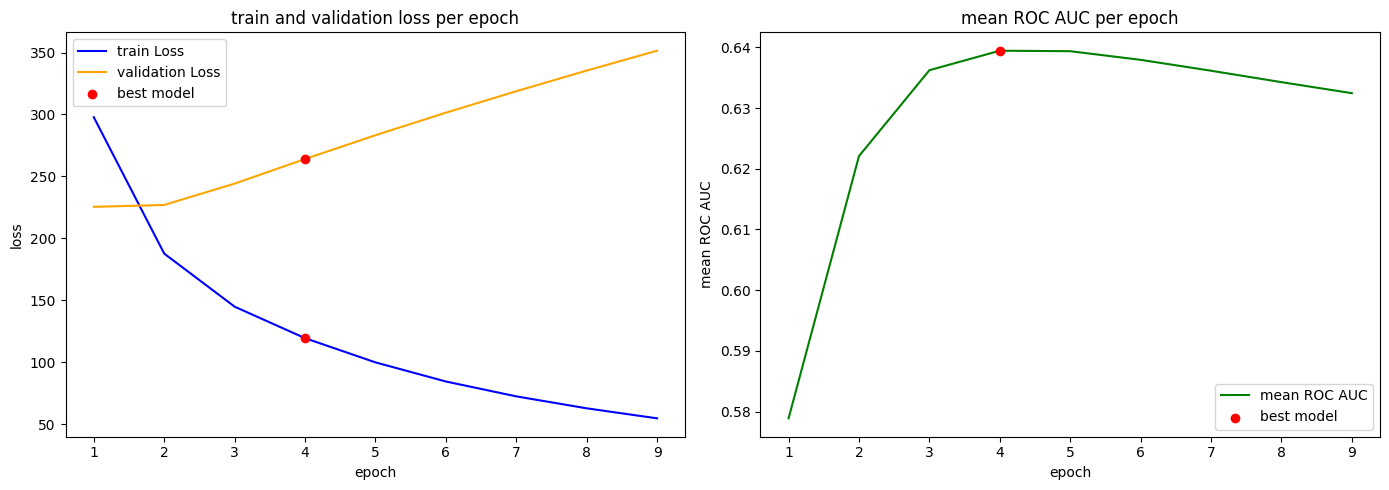

In [28]:
plot_training_results(train_losses_per_epoch, 
                      val_losses_per_epoch, 
                      mean_roc_aucs_per_epoch, 
                      best_epoch)